In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.linalg as linalg
import torch_geometric.utils as utils
import torch_geometric.nn as gnn
from torch.distributions import Bernoulli, MultivariateNormal
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, fill_diag, matmul, mul
from torch_sparse import sum as sparsesum
torch.set_printoptions(precision=2,sci_mode=False, linewidth=200)

## The XGMM and XCSBM synthetic data models

In [2]:
def XGMM(n_points, n_features, u, v, sig_sq):
    X = torch.zeros((n_points, n_features))
    y = torch.zeros(n_points, dtype=torch.long)
    # Decide class and cluster based on two independent Bernoullis.
    eps = Bernoulli(torch.tensor([0.5]))
    eta = Bernoulli(torch.tensor([0.5]))
    for i in range(n_points):
        mean = torch.randn(n_features)
        y[i] = eps.sample()
        cluster = eta.sample()
        # Mean is -mu, mu, -nu or nu based on eps_i and eta_i.
        mean = (2*cluster - 1)*((1-y[i])*u + y[i]*v)
        if sig_sq > 0:
            cov = torch.eye(n_features) * sig_sq
            distr = MultivariateNormal(mean, cov)
            X[i] = distr.sample()
        else:
            X[i] = mean
    return Data(x=X, y=y, edge_index=None)

def XCSBM(n_points, n_features, u, v, sig_sq, p, q):
    data = XGMM(n_points, n_features, u, v, sig_sq)
    
    # The inbuilt function stochastic_blockmodel_graph does not support
    # random permutations of the node, hence, design it manually.
    # Use with_replacement=True to include self-loops.
    probs = torch.tensor([[p, q], [q, p]], dtype=torch.float)
    row, col = torch.combinations(torch.arange(n_points), r=2, with_replacement=True).t()
    mask = torch.bernoulli(probs[data.y[row], data.y[col]]).to(torch.bool)
    data.edge_index = torch.stack([row[mask], col[mask]], dim=0)
    data.edge_index = utils.to_undirected(data.edge_index, num_nodes=n_points)
    return data

## Data generation

In [3]:
n_points = 800
n_features = 10
n_test_trials = 10
print("n_points:", n_points)
print("n_features:", n_features)

# Fix the variance to 1/n_features.
sig_sq = 1.0/n_features
sig = np.sqrt(sig_sq)

# mean_scale = K, where norm(u-v) = K*sigma.
mean_scale = np.logspace(-1, .05 + .5*np.log(np.log(n_points)), num=200)
# mean_scale = np.linspace(1./10., 1.2*np.log(n_points), num=100)
train_datasets = {}
test_datasets = {}
means = {}
for K in mean_scale:
    # We want norm(u-v) = K*sigma
    u = torch.rand(n_features) # First mean.
    # u[-1] = torch.abs(1) # To prevent division by 0.
    u /= linalg.norm(u)
    v = torch.rand(n_features) # Second mean.
    v[-1] = -(u[:-1] @ v[:-1]) / u[-1] # Make v orthogonal to u.
    v /= linalg.norm(v)
    means[K] = [u, v]

    # Make K = norm(u-v) = sqrt(2)*norm(u).
    K_ = K/np.sqrt(2.0)
    u_ = K_*u
    v_ = K_*v
    p = .8
    q = .1
    train_datasets[K] = XCSBM(n_points, n_features, u_, v_, sig_sq, p, q)
    test_datasets[K] = []
    for t in range(n_test_trials):
        test_datasets[K].append(XCSBM(n_points, n_features, u_, v_, sig_sq, p, q))

n_points: 800
n_features: 10


## MLPs/GCNs with ReLU activation

In [4]:
class MLP(torch.nn.Module):
    def __init__(self, n_layers, n_features, channels=None):
        super().__init__()
        self.activations = [nn.ReLU()]*n_layers
        self.activations[-1] = nn.Sigmoid()
        
        # Set default number of channels for every layer if not specified.
        # channels[0] stores input dimensions for each layer.
        # channels[1] stores output dimensions for each layer.
        if channels is None:
            in_channels = [4]*n_layers
            in_channels[0] = n_features
            out_channels = [4]*n_layers
            out_channels[-1] = 1
            channels = [in_channels, out_channels]
        
        assert channels[0][0] == n_features, "Input dimension of the first layer must match dimension of data."
        assert channels[1][-1] == 1, "Output dimension of the last layer must be 1."
        self.module_list = []
        for i in range(n_layers):
            self.module_list.append(nn.Sequential(
                nn.Linear(channels[0][i], channels[1][i], bias=False),
                self.activations[i]
            ))
        self.module_list = nn.ModuleList(self.module_list)

    def forward(self, data):
        x = data.x
        for module in self.module_list:
            x = module(x)
        out = torch.squeeze(x, dim=1)
        return out

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, n_layers, n_features, convolutions, channels=None):
        super().__init__()
        self.num_nodes = None
        self.norm = None
        self.convs = convolutions
        self.activations = [nn.ReLU()]*n_layers
        self.activations[-1] = nn.Sigmoid()
        
        # Set default number of channels for every layer if not specified.
        # channels[0] stores input dimensions for each layer.
        # channels[1] stores output dimensions for each layer.
        if channels is None:
            in_channels = [4]*n_layers
            in_channels[0] = n_features
            out_channels = [4]*n_layers
            out_channels[-1] = 1
            channels = [in_channels, out_channels]
        
        assert channels[0][0] == n_features, "Input dimension of the first layer must match dimension of data."
        assert channels[1][-1] == 1, "Output dimension of the last layer must be 1."
        assert len(convolutions) == n_layers, "Length of 'convolutions' must be the same as the number of layers."
        self.module_list = []
        for i in range(n_layers):
            self.module_list.append(nn.Sequential(
                nn.Linear(channels[0][i], channels[1][i], bias=False),
                self.activations[i]
            ))
        self.module_list = nn.ModuleList(self.module_list)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        if self.num_nodes is None:
            self.num_nodes = utils.num_nodes.maybe_num_nodes(edge_index)
            
            # Compute vector of deg^{-1}.
            edge_weight = torch.ones((edge_index.size(1), ), dtype=None, device=edge_index.device)
            row, col = edge_index
            deg = scatter_add(edge_weight, row, dim=0, dim_size=self.num_nodes)
            deg_inv = deg.pow_(-1)
            deg_inv[deg_inv == float('inf')] = 0
            self.norm = deg_inv.view(-1,1) # Normalize node features by deg^{-1}.
        for (i, module) in enumerate(self.module_list):
            x = self.convolve(x, edge_index, self.convs[i])
            x = module(x)
        out = torch.squeeze(x, dim=1)
        return out
    
    def convolve(self, x, edge_index, k):
        row, col = edge_index
        x_ = x
        for i in range(k):
            x_ = scatter_add(x_[row], col, dim=0, dim_size=self.num_nodes)
            x_ = self.norm*x_
        return x_

## Model training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

loss_fn = nn.BCELoss()
min_loss = 1e-3
epochs = 500
print_freq = epochs//5
mlps = {}
gcns = {}
train_loss_mlp = []
train_loss_gcn = []

# Fix network architectures for the networks.
channels = [[n_features, 4], [4, 1]]

print('Training', len(mean_scale), 'MLP and GCN models...')
for (j, K) in enumerate(mean_scale):
    data = train_datasets[K]
    # 2-layer MLP
    # Initialize with ansatz based on u, v.
    mlp = MLP(n_layers=2, n_features=n_features, channels=channels)
    params = [param for param in mlp.parameters()]
    params[0].data = torch.stack([u, -u, v, -v], dim=0)
    params[1].data = torch.tensor([[-1., -1., 1., 1.]])
    optimizer = torch.optim.Adam(mlp.parameters(), lr=0.02)
    mlp.train()
    for epoch in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        out = mlp(data)
        loss = loss_fn(out, data.y.float())
        if epoch % print_freq == 0:
            print('\r', j, ': MLP for K=', round(K, 2), ' -- Loss:', loss.item(), end='')
        
        loss.backward()
        optimizer.step()
        if loss.item() < min_loss:
            break
    
    mlp.eval()
    out = mlp(data)
    loss = loss_fn(out, data.y.float())
    train_loss_mlp.append(loss.item())
    mlps[K] = mlp
    
    # 2-layer GCN
    # Initialize with ansatz based on u, v.
    gcn = GCN(n_layers=2, n_features=n_features, convolutions=[0, 1], channels=channels)
    params = [param for param in gcn.parameters()]
    params[0].data = torch.stack([u, -u, v, -v], dim=0)
    params[1].data = torch.tensor([[-1., -1., 1., 1.]])
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.02)
    gcn.train()
    for epoch in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        out = gcn(data)
        loss = loss_fn(out, data.y.float())
        if epoch % print_freq == 0:
            print('\r', j, ': GCN for K=', round(K, 2), ' -- Loss:', loss.item(), end='')
        
        loss.backward()
        optimizer.step()
        if loss.item() < min_loss:
            break
    
    gcn.eval()
    out = gcn(data)
    loss = loss_fn(out, data.y.float())
    train_loss_gcn.append(loss.item())
    gcns[K] = gcn

Using device: cpu
Training 200 MLP and GCN models...
 199 : GCN for K= 10.0  -- Loss: 0.0051061124540865423

## Model evaluation

In [7]:
test_loss_mlp = []
test_loss_gcn = []
for K in mean_scale:
    loss_mlp = 0
    loss_gcn = 0
    for t in range(n_test_trials):
        data = test_datasets[K][t]
        
        # Loss of MLP on the training dataset.
        pred = mlps[K](data)
        loss_mlp += loss_fn(pred, data.y.float()).item()
        
        # Loss of GCN on the training dataset.
        pred = gcns[K](data)
        loss_gcn += loss_fn(pred, data.y.float()).item()
    
    test_loss_mlp.append(loss_mlp/n_test_trials)
    test_loss_gcn.append(loss_gcn/n_test_trials)

## Comparison of the loss

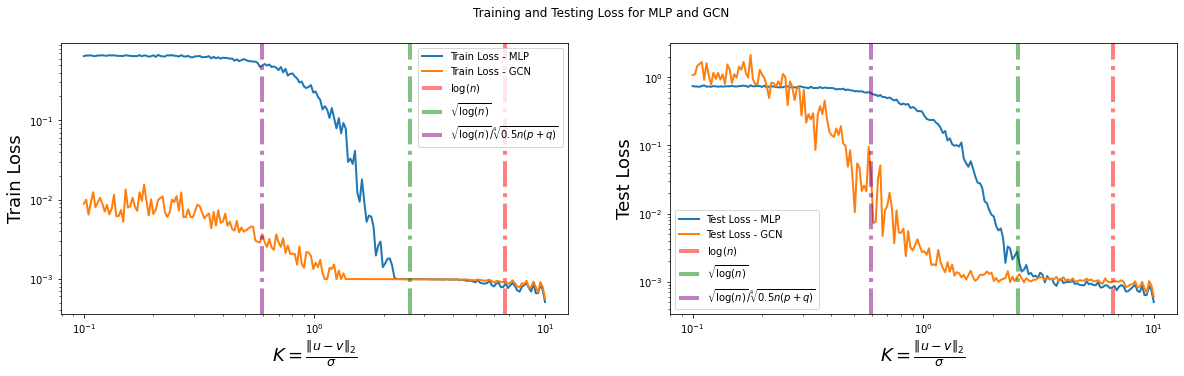

In [18]:
fig = plt.figure(figsize=(20,5), facecolor=[1,1,1])
gs = fig.add_gridspec(1, 2, hspace=0)
axs = gs.subplots()#sharex=True)
fig.suptitle('Training and Testing Loss for MLP and GCN')
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    
axs[0].plot(mean_scale, train_loss_mlp, linewidth=2, linestyle= '-', marker='', markersize=10, label='Train Loss - MLP')
axs[0].plot(mean_scale, train_loss_gcn, linewidth=2, linestyle= '-', marker='', markersize=10, label='Train Loss - GCN')
axs[0].set_ylabel(r'Train Loss', fontsize=18)
axs[1].plot(mean_scale, test_loss_mlp, linewidth=2, linestyle= '-', marker='', markersize=10, label='Test Loss - MLP')
axs[1].plot(mean_scale, test_loss_gcn, linewidth=2, linestyle= '-', marker='', markersize=10, label='Test Loss - GCN')
axs[1].set_ylabel(r'Test Loss', fontsize=18)
for i in range(2):
    axs[i].axvline(x=np.log(n_points), color='red', linewidth=4, linestyle='-.', alpha=0.5, label=r'$\log(n)$')
    axs[i].axvline(x=np.sqrt(np.log(n_points)), color='green', linewidth=4, linestyle='-.', alpha=0.5, label=r'$\sqrt{\log(n)}$')
    axs[i].axvline(x=np.sqrt(np.log(n_points)/np.sqrt(0.5*n_points*(p+q))), color='purple', linewidth=4, linestyle='-.', alpha=0.5, label=r'$\sqrt{\log(n)}/\sqrt[4]{0.5n(p+q)}$')
    axs[i].set_xlabel(r'$K = \frac{\Vert u-v \Vert_2}{\sigma}$', fontsize=18)
    axs[i].legend()